In [1]:
import skimage.data
import skimage.color
import matplotlib.pyplot
import scipy.fft
import numpy

shape : (400, 400)


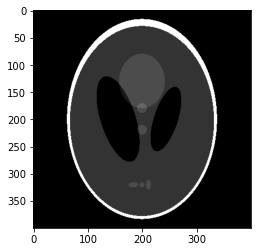

In [2]:
phantom_grayscale: numpy.ndarray = skimage.data.shepp_logan_phantom()
print('shape :', phantom_grayscale.shape)
matplotlib.pyplot.imshow(phantom_grayscale, cmap='gray')

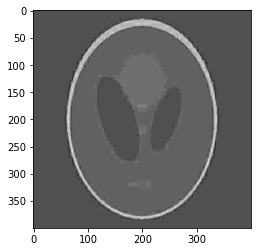

In [3]:
# https://en.wikipedia.org/wiki/Quantization_(image_processing)
quantization_matrix = \
    numpy.array(
        [
            [16, 11, 10, 16, 24, 40, 51, 61],
            [12, 12, 14, 19, 26, 58, 60, 55],
            [14, 13, 16, 24, 40, 57, 69, 56],
            [14, 17, 22, 29, 51, 87, 80, 62],
            [18, 22, 37, 56, 68, 109, 103, 77],
            [24, 35, 55, 64, 81, 104, 113, 92],
            [49, 64, 78, 87, 103, 121, 120, 101],
            [72, 92, 95, 98, 112, 100, 103, 99]
        ]
    )

block_size = 8 # 8x8

phantom_artifacts = numpy.zeros(phantom_grayscale.shape)


for i in range(0, phantom_artifacts.shape[0], block_size):
    for j in range(0, phantom_artifacts.shape[1], block_size):
        dct = scipy.fft.dctn(phantom_grayscale[i:i+block_size, j:j+block_size])
        dct = numpy.round(dct/quantization_matrix)
        phantom_artifacts[i:i+block_size, j:j+block_size] = scipy.fft.idctn(dct)


matplotlib.pyplot.imshow(phantom_artifacts, cmap='gray')



In [4]:
def add_artifacts(img_grayscale: numpy.ndarray, intensity: float) -> numpy.ndarray:

    img_artifacts: numpy.ndarray = numpy.zeros(img_grayscale.shape)

    # Source : https://en.wikipedia.org/wiki/Quantization_(image_processing)
    quantization_table: numpy.ndarray = \
        numpy.array(
            [
                [16, 11, 10, 16, 24, 40, 51, 61],
                [12, 12, 14, 19, 26, 58, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]
            ]
        )

    # Quality of image
    quality: float = 100-intensity
    # Size of block for processing
    block_size: int = quantization_table.shape[0] # 8
    
    ## Source : https://stackoverflow.com/questions/29215879/how-can-i-generalize-the-quantization-matrix-in-jpeg-compression
    # Determine factor S for Quantization Table
    S: float = 5_000/quality if quality < 50 else 200 - 2*quality

    # Define quantization matrix altered
    quantization_table_S: numpy.ndarray = numpy.floor((S*quantization_table+50) / 100)
    # Prevent "divide by 0"
    quantization_table_S[quantization_table_S==0] = 1

    # Block processing 8x8
    for i in range(0, img_artifacts.shape[0], block_size):
        for j in range(0, img_artifacts.shape[1], block_size):
            # DCT on 8x8 block
            dct: numpy.ndarray = scipy.fft.dctn(img_grayscale[i:i+block_size, j:j+block_size])
            # Divide by quantification table/coefs
            dct: numpy.ndarray = numpy.round(dct/quantization_table_S)
            # inverse DCT
            img_artifacts[i:i+block_size, j:j+block_size] = scipy.fft.idctn(dct)

    return img_artifacts

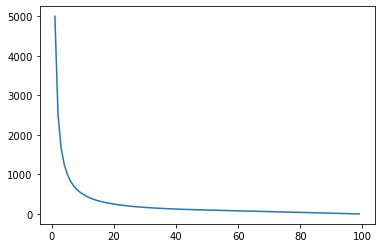

In [5]:
qualities = []
list_s = []
for quality in range(1, 100):
    S: float = 5_000/quality if quality < 50 else 200 - 2*quality
    qualities.append(quality)
    list_s.append(S)

matplotlib.pyplot.plot(qualities, list_s)
matplotlib.pyplot.show()

In [8]:
intensity_values: list[float] = [ i for i in range(10, 99, 10) ]
NB_PLOTS: int = len(intensity_values)

for index in range(0, NB_PLOTS):

    intensity: float = intensity_values[index]
    phantom_artifacts: numpy.ndarray = add_artifacts(img_grayscale=phantom_grayscale, intensity=intensity)

    name: str = 'phantom-intensity-'+str(intensity)
    matplotlib.pyplot.imsave('phantom-datas/Artifacts/'+name+'.jpg', phantom_artifacts)
    matplotlib.pyplot.imsave('phantom-datas/Results/'+name+'.png', phantom_grayscale)

# matplotlib.pyplot.imshow(add_artifacts(phantom_grayscale, intensity=40), cmap='gray')